In [363]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout

In [364]:
df = (yf.download('MSFT', interval='1d'))[['Close']]

[*********************100%%**********************]  1 of 1 completed


In [366]:
df = df[df.index.year >= 2000]

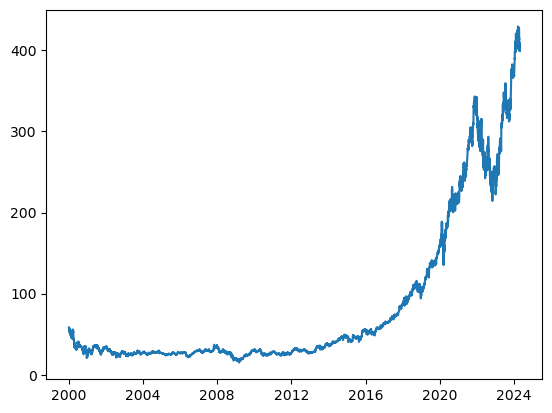

In [367]:
plt.plot(df)

In [368]:
scaler = MinMaxScaler()
df.loc[:, 'Close'] = scaler.fit_transform(df[['Close']]).flatten()

In [369]:
window_size = 91
X, y = [], []

for i in range(window_size, len(df)):
    feature = np.array(df['Close'].iloc[i-window_size:i])
    target = np.array(df['Close'].iloc[i])

    X.append(feature)
    y.append(target)

X, y = np.array(X), np.array(y)

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    train_val_split = int(len(train_index) * 0.8)
    X_train, X_val = X_train[:train_val_split], X_train[train_val_split:]
    y_train, y_val = y_train[:train_val_split], y_train[train_val_split:]

In [370]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [372]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print("Number of samples in X_train:", len(X_train))
print("Shape of the first sample in X_train:", X_train[0].shape)

Number of samples in X_train: 4018
Shape of the first sample in X_train: (91, 1)


In [373]:
### FEED FORWARD NN ###

ff_model = Sequential()
ff_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
ff_model.add(Dropout(0.2))
ff_model.add(Dense(64, activation='relu'))
ff_model.add(Dropout(0.2))
ff_model.add(Dense(1))
ff_model.compile(optimizer='adam', loss='mean_squared_error')
ff_model.summary()
ff_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                5888      
                                                                 
 dropout_30 (Dropout)        (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dropout_31 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10113 (39.50 KB)
Trainable params: 10113 (39.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
126/12

In [374]:
### PREDICTION OF NEXT 91 DAYS ###

last_window = np.array(df['Close'].iloc[-window_size:])
input_data = np.reshape(last_window, (1, window_size, 1)) # shape --> (1, 91, 1)

for i in range(window_size):
    y_pred = model.predict(input_data)
    input_data = np.append(input_data, y_pred.reshape(1, 1, 1), axis=1)
    input_data = input_data[:, 1:, :]

1/1 [==============================] - 0s 30ms/step


In [375]:
predicted_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=window_size)
predicted_df = pd.DataFrame(input_data.squeeze(), index=predicted_dates, columns=['Close'])
extended_df = pd.concat([df, predicted_df])

df['Close'] = scaler.inverse_transform(df[['Close']])
extended_df['Close'] = scaler.inverse_transform(extended_df[['Close']])

fig = go.Figure()

fig.add_trace(go.Scatter(x=extended_df.index, y=extended_df['Close'], mode='lines', name='Predicted Data', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=df.index, y=df['Close'], mode='lines', name='Historical Data', line=dict(color='blue')))

fig.update_layout(
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price'),
    title='Historical Data and Predicted Trend',
    legend=dict(x=0, y=1),
    width=1200,
    height=600
)

fig.show()

In [376]:
y_pred_test = model.predict(X_test)

y_pred_test = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index[-len(y_test):], y=y_pred_test.flatten(), mode='lines', name='Predicted Data (X_test)', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=df.index[-len(y_test):], y=y_test_inv.flatten(), mode='lines', name='Actual Data (y_test)', line=dict(color='blue')))

fig.update_layout(
    xaxis=dict(title='Date'),
    yaxis=dict(title='ClosePrice'),
    title='Actual vs Predicted Trend on Test Data',
    legend=dict(x=0, y=1),
    width=1200,
    height=600
)

fig.show()


32/32 [==============================] - 1s 20ms/step


In [377]:
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

32/32 [==============================] - 1s 19ms/step - loss: 0.0102
Test Loss: 0.01023695059120655
